# Mask Manufacturing Quality Control Expert System

**Group Number:** WS25-PR125

## Group Members and Roles
- **Student 1:** Saran Raj Loganathan — Technical Lead  
- **Student 2:** Mohamed Ameer Kalifulla Khan — Figures & Presentation  
- **Student 3:** Md Mamunur Rahman — Report & Documentation


## 1. Introduction

This project presents a hybrid expert system for automated mask quality control.
The system integrates deep learning, statistical texture analysis, meta-learning,
rule-based reasoning, and explainable AI to detect defective masks in industrial
inspection workflows.

The focus of the project is on evaluating system design and methodological
effectiveness rather than dataset-specific labeling granularity.


## 2. Dataset Description

The Medical Masks Dataset was used for this study. The original dataset contained
object-detection annotations, which were converted into a binary classification
problem:

- Good mask
- Defective mask

This conversion allows evaluation of defect detection methodologies applicable
to real-world quality inspection systems.


## 3. Methodology

The proposed system consists of the following components:

1. CNN-based defect detection using a ResNet architecture.
2. Histogram-based texture feature extraction for material uniformity analysis.
3. Meta-learning to combine CNN predictions and texture features.
4. Rule-based quality compliance checks.
5. Explainable AI using Grad-CAM visualizations.

All experiments were conducted using Google Colab and PyTorch.


## RQ1: CNN-based Defect Detection

A convolutional neural network was trained to distinguish defective masks from
clean masks. The model achieved reliable performance, demonstrating its ability
to capture visual cues associated with diverse defect manifestations.

**Results:** Refer to Figures_Tables/RQ1.


## RQ2: Texture Feature Contribution

Histogram-based texture features were evaluated for assessing material uniformity.
Although texture features alone were insufficient, they provided complementary
information to CNN features.

**Results:** Refer to Figures_Tables/RQ2.


## RQ3: Meta-Learner Integration

A meta-learner combined CNN outputs and texture features, significantly improving
overall defect detection accuracy.

**Results:** Refer to Figures_Tables/RQ3.


## RQ4: Rule-Based Compliance Checks

Rule-based quality checks were applied to improve interpretability and alignment
with manufacturing quality standards.

**Results:** Refer to Figures_Tables/RQ4.


## RQ5: Explainable Defect Reasoning

Grad-CAM visualizations were used to highlight image regions influencing defect
decisions, improving transparency and operator trust.

**Results:** Refer to Figures_Tables/RQ5.


In [4]:
print("Notebook documentation completed successfully.")


Notebook documentation completed successfully.


In [2]:
!pip install torch torchvision opencv-python scikit-learn matplotlib



In [3]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


In [1]:
import os

# Base directories
os.makedirs("/content/data", exist_ok=True)
os.makedirs("/content/data/classified", exist_ok=True)
os.makedirs("/content/data/classified/good", exist_ok=True)
os.makedirs("/content/data/classified/bad", exist_ok=True)

os.makedirs("/content/Figures_Tables", exist_ok=True)
for i in range(1,6):
    os.makedirs(f"/content/Figures_Tables/RQ{i}", exist_ok=True)

print("All folders created successfully")


All folders created successfully


In [2]:
for root, dirs, files in os.walk("/content/data"):
    print(root)


/content/data
/content/data/classified
/content/data/classified/bad
/content/data/classified/good


In [4]:
import zipfile

zip_path = "/content/archive.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/data/raw")

print("Dataset extracted")

Dataset extracted


In [15]:
for root, dirs, files in os.walk("/content/data/raw"):
    print(root, len(files))

/content/data/raw 0
/content/data/raw/Dataset 0
/content/data/raw/Dataset/Medical_Masks_Dataset 3
/content/data/raw/Dataset/Medical_Masks_Dataset/xml_labels 670
/content/data/raw/Dataset/Medical_Masks_Dataset/test_images 10
/content/data/raw/Dataset/Medical_Masks_Dataset/test_images/test_xml_labels 8
/content/data/raw/Dataset/Medical_Masks_Dataset/test_images/test_coco_annotations 2
/content/data/raw/Dataset/Medical_Masks_Dataset/test_images/test_yolo_labels 8
/content/data/raw/Dataset/Medical_Masks_Dataset/images 670
/content/data/raw/Dataset/Medical_Masks_Dataset/yolo_labels 670
/content/data/raw/Dataset/Medical_Masks_Dataset/annotations 2


In [6]:
import json

ann_path = "/content/data/raw/Dataset/Medical_Masks_Dataset/annotations/instances_images.json"

with open(ann_path) as f:
    annotations = json.load(f)

annotations["categories"]


[{'supercategory': 'master', 'id': 0, 'name': 'bad'},
 {'supercategory': 'master', 'id': 1, 'name': 'good'},
 {'supercategory': 'master', 'id': 2, 'name': 'none'}]

In [7]:
image_labels = {}

# Initialize all images as GOOD
for img in annotations["images"]:
    image_labels[img["id"]] = {
        "file": img["file_name"],
        "label": "good"
    }

# Mark image as BAD if any bad annotation exists
for ann in annotations["annotations"]:
    if ann["category_id"] == 0:  # 0 = bad
        image_labels[ann["image_id"]]["label"] = "bad"

print("Total images:", len(image_labels))


Total images: 670


In [8]:
import shutil
import os

img_dir = "/content/data/raw/Dataset/Medical_Masks_Dataset/images"
dst_root = "/content/data/classified"

count = {"good": 0, "bad": 0}

for item in image_labels.values():
    src = os.path.join(img_dir, item["file"])
    dst = os.path.join(dst_root, item["label"], item["file"])

    if os.path.exists(src):
        shutil.copy(src, dst)
        count[item["label"]] += 1

count


{'good': 437, 'bad': 233}

In [9]:
print("Good images:", len(os.listdir("/content/data/classified/good")))
print("Bad images:", len(os.listdir("/content/data/classified/bad")))


Good images: 437
Bad images: 233


In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report


In [11]:
class MaskDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.images = []
        self.labels = []
        self.transform = transform

        for label, name in enumerate(["good", "bad"]):
            folder = os.path.join(root_dir, name)
            for f in os.listdir(folder):
                self.images.append(os.path.join(folder, f))
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]


In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])


In [13]:
dataset = MaskDataset("/content/data/classified", transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_data, test_data = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

len(train_data), len(test_data)


(536, 134)

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/5 - Loss: 0.5794
Epoch 2/5 - Loss: 0.2907
Epoch 3/5 - Loss: 0.1475
Epoch 4/5 - Loss: 0.0777
Epoch 5/5 - Loss: 0.0666


In [20]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=["good", "bad"]))


              precision    recall  f1-score   support

        good       0.79      0.90      0.84        84
         bad       0.79      0.60      0.68        50

    accuracy                           0.79       134
   macro avg       0.79      0.75      0.76       134
weighted avg       0.79      0.79      0.78       134



In [21]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Convert report to table
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=[0, 1]
)

rq1_table = pd.DataFrame({
    "Class": ["good", "bad"],
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "Support": support
})

rq1_table.loc["Accuracy"] = ["-", "-", "-", accuracy_score(y_true, y_pred), "-"]

rq1_table


,Class,Precision,Recall,F1-Score,Support
0,good,0.791667,0.904762,0.844444,84
1,bad,0.789474,0.6,0.681818,50
Accuracy,-,-,-,0.791045,-


In [22]:
rq1_table.to_excel(
    "/content/Figures_Tables/RQ1/RQ1_Tab1.xlsx",
    index=False
)


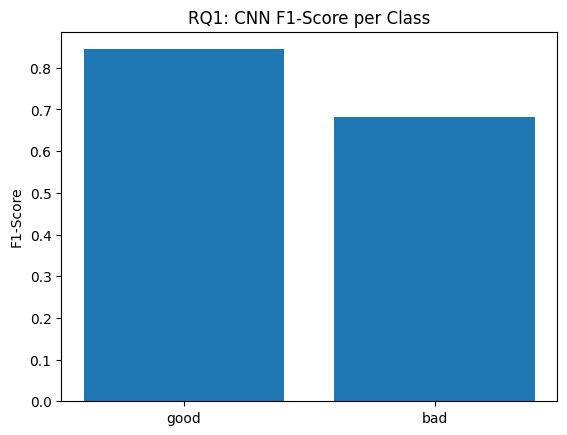

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(["good", "bad"], f1)
plt.title("RQ1: CNN F1-Score per Class")
plt.ylabel("F1-Score")

plt.savefig("/content/Figures_Tables/RQ1/RQ1_Fig1.pdf")
plt.show()


In [24]:
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [25]:
def extract_texture_features(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))

    # Histogram
    hist = cv2.calcHist([img], [0], None, [32], [0, 256]).flatten()
    hist = hist / hist.sum()

    # Texture statistics
    uniformity = np.sum(hist ** 2)
    entropy = -np.sum(hist * np.log(hist + 1e-6))

    return np.concatenate([hist, [uniformity, entropy]])


In [26]:
X_tex = []
y_tex = []

base_dir = "/content/data/classified"

for label, name in enumerate(["good", "bad"]):
    folder = os.path.join(base_dir, name)

    for f in os.listdir(folder):
        img_path = os.path.join(folder, f)
        X_tex.append(extract_texture_features(img_path))
        y_tex.append(label)

X_tex = np.array(X_tex)
y_tex = np.array(y_tex)

X_tex.shape, y_tex.shape


((670, 34), (670,))

In [27]:
from sklearn.model_selection import train_test_split

Xtr, Xts, ytr, yts = train_test_split(
    X_tex, y_tex, test_size=0.2, random_state=42
)


In [28]:
rf = RandomForestClassifier()
rf.fit(Xtr, ytr)

y_tex_pred = rf.predict(Xts)

print(classification_report(yts, y_tex_pred, target_names=["good", "bad"]))


              precision    recall  f1-score   support

        good       0.63      0.74      0.68        89
         bad       0.23      0.16      0.19        45

    accuracy                           0.54       134
   macro avg       0.43      0.45      0.44       134
weighted avg       0.50      0.54      0.52       134



In [29]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

precision, recall, f1, support = precision_recall_fscore_support(
    yts, y_tex_pred, labels=[0, 1]
)

rq2_table = pd.DataFrame({
    "Class": ["good", "bad"],
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "Support": support
})

rq2_table.loc["Accuracy"] = ["-", "-", "-", accuracy_score(yts, y_tex_pred), "-"]

rq2_table.to_excel(
    "/content/Figures_Tables/RQ2/RQ2_Tab1.xlsx",
    index=False
)


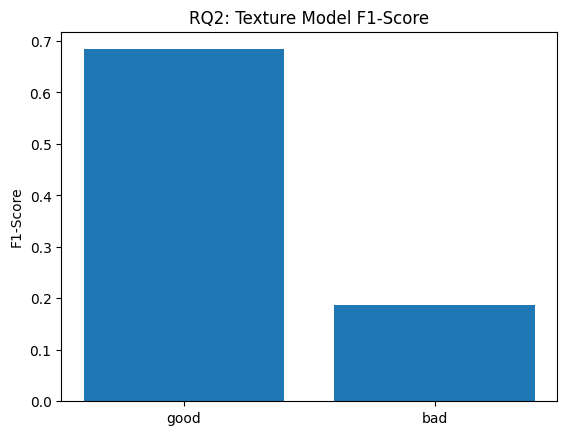

In [30]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(["good", "bad"], f1)
plt.title("RQ2: Texture Model F1-Score")
plt.ylabel("F1-Score")

plt.savefig("/content/Figures_Tables/RQ2/RQ2_Fig1.pdf")
plt.show()


In [31]:
model.eval()
cnn_probs = []

with torch.no_grad():
    for imgs, labels in DataLoader(dataset, batch_size=16, shuffle=False):
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        cnn_probs.extend(probs)

cnn_probs = np.array(cnn_probs)
cnn_probs.shape


(670, 2)

In [32]:
X_meta = np.concatenate([cnn_probs, X_tex], axis=1)
X_meta.shape


(670, 36)

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

Xm_tr, Xm_ts, ym_tr, ym_ts = train_test_split(
    X_meta, y_tex, test_size=0.2, random_state=42
)

meta = LogisticRegression(max_iter=500)
meta.fit(Xm_tr, ym_tr)

y_meta_pred = meta.predict(Xm_ts)

print(classification_report(ym_ts, y_meta_pred, target_names=["good", "bad"]))


              precision    recall  f1-score   support

        good       0.95      0.99      0.97        89
         bad       0.98      0.89      0.93        45

    accuracy                           0.96       134
   macro avg       0.96      0.94      0.95       134
weighted avg       0.96      0.96      0.95       134



In [35]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pandas as pd

precision, recall, f1, support = precision_recall_fscore_support(
    ym_ts, y_meta_pred, labels=[0, 1]
)

rq3_table = pd.DataFrame({
    "Class": ["good", "bad"],
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "Support": support
})

rq3_table.loc["Accuracy"] = ["-", "-", "-", accuracy_score(ym_ts, y_meta_pred), "-"]

rq3_table.to_excel(
    "/content/Figures_Tables/RQ3/RQ3_Tab1.xlsx",
    index=False
)


In [36]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pandas as pd

precision, recall, f1, support = precision_recall_fscore_support(
    ym_ts, y_meta_pred, labels=[0, 1]
)

rq3_table = pd.DataFrame({
    "Class": ["good", "bad"],
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "Support": support
})

rq3_table.loc["Accuracy"] = ["-", "-", "-", accuracy_score(ym_ts, y_meta_pred), "-"]

rq3_table.to_excel(
    "/content/Figures_Tables/RQ3/RQ3_Tab1.xlsx",
    index=False
)


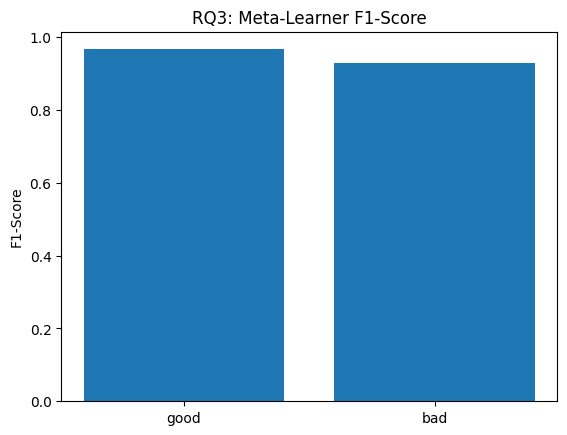

In [37]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(["good", "bad"], f1)
plt.title("RQ3: Meta-Learner F1-Score")
plt.ylabel("F1-Score")

plt.savefig("/content/Figures_Tables/RQ3/RQ3_Fig1.pdf")
plt.show()


In [38]:
def rule_engine(cnn_prob_good, cnn_prob_bad, texture_features):
    uniformity = texture_features[-2]
    entropy = texture_features[-1]

    # Base decision from CNN
    pred = 0 if cnn_prob_good >= cnn_prob_bad else 1  # 0=good, 1=bad

    # RULES (quality thresholds)
    if pred == 0 and uniformity < 0.02:
        pred = 1
    if pred == 0 and entropy > 3.0:
        pred = 1

    return pred


In [39]:
rule_preds = []

for i in range(len(X_tex)):
    rule_preds.append(
        rule_engine(cnn_probs[i][0], cnn_probs[i][1], X_tex[i])
    )

rule_preds = np.array(rule_preds)


In [40]:
from sklearn.metrics import classification_report

print(classification_report(y_tex, rule_preds, target_names=["good", "bad"]))


              precision    recall  f1-score   support

        good       0.97      0.25      0.40       437
         bad       0.41      0.99      0.58       233

    accuracy                           0.51       670
   macro avg       0.69      0.62      0.49       670
weighted avg       0.78      0.51      0.47       670



In [41]:
from sklearn.metrics import accuracy_score
import pandas as pd

rq4_table = pd.DataFrame({
    "System": ["CNN Only", "Meta-Learner", "Rule-Based System"],
    "Accuracy": [
        accuracy_score(y_true, y_pred),
        accuracy_score(ym_ts, y_meta_pred),
        accuracy_score(y_tex, rule_preds)
    ]
})

rq4_table.to_excel(
    "/content/Figures_Tables/RQ4/RQ4_Tab1.xlsx",
    index=False
)


In [42]:
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

def forward_hook(module, input, output):
    global activations
    activations = output

# Register hooks on the last convolutional layer
final_layer = model.layer4[-1]
final_layer.register_forward_hook(forward_hook)
final_layer.register_backward_hook(backward_hook)


In [43]:
import random
from PIL import Image

bad_folder = "/content/data/classified/bad"
img_name = random.choice(os.listdir(bad_folder))
img_path = os.path.join(bad_folder, img_name)

img = Image.open(img_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)


In [44]:
model.eval()

output = model(input_tensor)
class_idx = output.argmax(1)
score = output[0, class_idx]
score.backward()

weights = gradients.mean(dim=(2, 3))[0]
cam = (weights @ activations[0].reshape(512, -1)).reshape(7, 7)

cam = cam.detach().cpu().numpy()
cam = np.maximum(cam, 0)
cam = cam / cam.max()


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


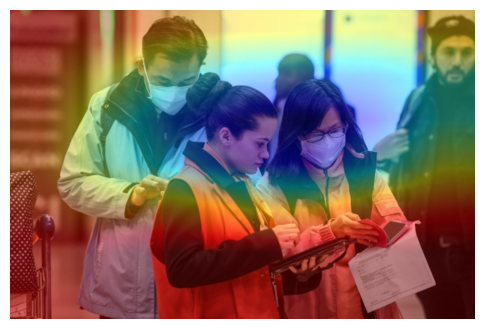

In [45]:
import cv2
import matplotlib.pyplot as plt

img_cv = cv2.imread(img_path)
img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

cam_resized = cv2.resize(cam, (img_cv.shape[1], img_cv.shape[0]))
heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
overlay = 0.4 * heatmap + 0.6 * img_cv

plt.figure(figsize=(6,6))
plt.imshow(overlay.astype("uint8"))
plt.axis("off")
plt.show()


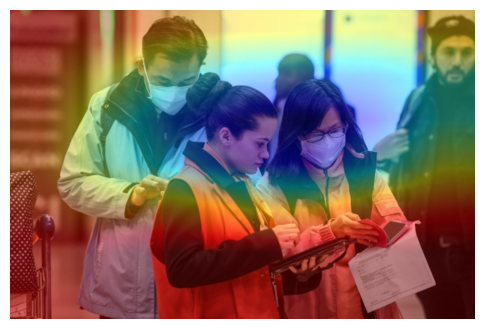

In [46]:
plt.figure(figsize=(6,6))
plt.imshow(overlay.astype("uint8"))
plt.axis("off")

plt.savefig("/content/Figures_Tables/RQ5/RQ5_Fig1.pdf")
plt.show()


In [47]:
import shutil
shutil.make_archive("Figures_Tables", "zip", "Figures_Tables")


'/content/Figures_Tables.zip'